# Support Vector Regression for Price Prediction

Use Technical Analysis indicators as input features.

Split train/test
Fit SVR to technical indicators.
Report mean squared error.

Prediction for single stock. In this notebook, ADVANC is chosen arbitrary.
- Predict tomorrow's closing price.
- Use five technical indicators.
- Technical indicator choice and methodology came from Henrique2018.
- Model trained using data from 2014-2016. Model test on holdout data set of 2017, 2018-2020.
- Linear Kernel perform better than RBF. Confirms literature knowledge. RBF was getting 88 MSE on training.


MSE (Linear Kernel)


| | In-sample (Training) | Out-of-sample (Holdout) | Out-of-sample (Holdout) |
| --- | --- | --- | --- |
| Year | 2014-2016 | 2017 | 2018-2020 |
| MSE | 24.08 | 22.96 | 19.39 |
| MAE | 3.12 | 3.98 | 3.47 |
| R2 | 0.97 | 0.60 | 0.92 |

TODO:
- Try Three-day, Five-day, Ten-day, Twenty-day ahead.


References
- HENRIQUE, Bruno Miranda; SOBREIRO, Vinicius Amorim; KIMURA, Herbert. Stock price prediction using support vector regression on daily and up to the minute prices. The Journal of finance and data science, 2018, 4.3: 183-201.
- Support Vector Regression in Python Using Scikit-Learn https://heartbeat.fritz.ai/support-vector-regression-in-python-using-scikit-learn-89cc18e933b7
- In-Depth: Support Vector Machines https://jakevdp.github.io/PythonDataScienceHandbook/05.07-support-vector-machines.html#Fitting-a-support-vector-machine
- Support vector regression for multivariate time series prediction
https://stats.stackexchange.com/questions/14482/support-vector-regression-for-multivariate-time-series-prediction
- SVM From Scratch — Python https://towardsdatascience.com/svm-implementation-from-scratch-python-2db2fc52e5c2
- Support Vector Regression in 6 Steps with Python https://medium.com/pursuitnotes/support-vector-regression-in-6-steps-with-python-c4569acd062d
- Awad M., Khanna R. (2015) Support Vector Regression. In: Efficient Learning Machines. Apress, Berkeley, CA https://link.springer.com/chapter/10.1007/978-1-4302-5990-9_4

In [82]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score,mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import os, os.path
import talib

In [83]:
DATA_HOME = os.path.join("..","historical")

symbols = ["ADVANC","BTS"]
data = {}
for s in symbols:
    data[s] = pd.read_csv(os.path.join(DATA_HOME,"%s.csv" % s), index_col=0)

df = data["ADVANC"]
df.index = pd.to_datetime(df.index)
daily = df['2014-01-01':'2016-12-31']

In [14]:
from talib.abstract import *

inputs = {
    'open': daily["Open"],
    'high': daily["High"],
    'low': daily["Low"],
    'close': daily["Close"],
    'volume': daily["Volume"]
}

daily["SMA"] = SMA(inputs, timeperiod=25).tolist()
daily["WMA"] = WMA(inputs).tolist()
daily["ADOSC"] = ADOSC(inputs).tolist()
daily["ATR"] = ATR(inputs).tolist()
daily["RSI"] = RSI(inputs).tolist()
daily["AD"] = AD(inputs).tolist()

daily

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,High,Low,Open,Close,Volume,Adj Close,SMA,ATR,RSI,AD,WMA,ADOSC
Date,,,,,,,,,,,,
2014-01-02,198.5,187.0,198.0,187.0,12694200.0,137.609299,NaN,NaN,NaN,-1.269420e+07,NaN,NaN
2014-01-03,196.0,186.5,187.0,196.0,16987100.0,144.232224,NaN,NaN,NaN,4.292900e+06,NaN,NaN
2014-01-06,203.0,191.0,195.0,201.0,10294700.0,147.911621,NaN,NaN,NaN,1.115603e+07,NaN,NaN
2014-01-07,210.0,200.0,205.0,210.0,11479200.0,154.534515,NaN,NaN,NaN,2.263523e+07,NaN,NaN
2014-01-08,210.0,203.0,208.0,206.0,13653100.0,151.591019,NaN,NaN,NaN,2.068479e+07,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-26,145.5,144.5,145.0,145.0,2073000.0,126.894188,144.90,1.893209,43.464502,-5.490516e+08,145.230108,-3.471817e+06
2016-12-27,145.5,144.0,145.5,144.0,2083000.0,126.019043,144.92,1.865123,39.681142,-5.511346e+08,145.162366,-3.667613e+06
2016-12-28,145.0,144.0,144.5,144.5,2412300.0,126.456635,144.96,1.803328,42.381727,-5.511346e+08,145.137634,-3.414293e+06


# Prepare feature

We want X,y before splitting.

In [36]:


# Target: Tomorrow's closing price
data["Tomorrow"] = data["Close"].shift(-1)
data = data.dropna()

# Features: SMA, ATR, RSI AD

features = data[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
target = data[["Tomorrow"]].values

# data[[SMA, WMA, RSI, ADOSC, ATR]]
data

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,High,Low,Open,Close,Volume,Adj Close,SMA,ATR,RSI,AD,WMA,ADOSC,Tomorrow
Date,,,,,,,,,,,,,
2014-02-12,215.0,210.0,210.0,214.0,7204000.0,157.478012,210.10,6.083446,61.439766,2.997581e+07,210.405376,4.086292e+05,215.0
2014-02-13,216.0,213.0,214.0,215.0,4674700.0,158.213928,210.58,5.863200,62.273511,3.153405e+07,210.830108,1.294266e+06,222.0
2014-02-17,222.0,214.0,216.0,222.0,8395400.0,163.365067,211.48,6.015829,67.560940,3.992945e+07,211.646237,4.210176e+06,219.0
2014-02-18,221.0,217.0,220.0,219.0,6289500.0,161.157425,211.88,5.943270,63.456249,3.992945e+07,212.212903,5.020304e+06,217.0
2014-02-19,224.0,214.0,219.0,217.0,8990800.0,159.685638,212.08,6.233036,60.804024,3.633313e+07,212.611828,3.751046e+06,211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,145.5,144.0,145.0,144.5,3364400.0,126.456635,144.84,1.961917,40.845937,-5.490516e+08,145.245161,-3.841799e+06,145.0
2016-12-26,145.5,144.5,145.0,145.0,2073000.0,126.894188,144.90,1.893209,43.464502,-5.490516e+08,145.230108,-3.471817e+06,144.0
2016-12-27,145.5,144.0,145.5,144.0,2083000.0,126.019043,144.92,1.865123,39.681142,-5.511346e+08,145.162366,-3.667613e+06,144.5


In [37]:
X = features
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [38]:
# Note about pipeline
# see https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

svr = SVR(kernel='rbf')
model = make_pipeline(StandardScaler(), svr)

In [39]:
model.fit(X_train, y_train)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svr',
                 SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
                     gamma='scale', kernel='rbf', max_iter=-1, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [40]:
y_pred = model.predict(X_test)
y_pred

array([171.16085431, 225.16410094, 238.02563651, 161.85586478,
       170.28447203, 225.2021951 , 229.65251356, 155.01441896,
       164.51303088, 233.46839392, 236.28617891, 183.13787502,
       184.61979367, 167.08183832, 204.36356053, 236.04002502,
       207.86786875, 229.35829813, 214.1269777 , 161.79988526,
       181.29057238, 162.96099074, 197.63140701, 182.43621253,
       225.95266035, 161.82960511, 234.01945132, 169.04654647,
       234.02390079, 154.58238705, 228.20827255, 225.84722127,
       205.70100648, 234.63552157, 166.88317303, 240.58467341,
       217.51582196, 162.87715824, 156.89999709, 175.94554905,
       160.18963835, 234.59877319, 207.2401782 , 158.70672953,
       225.47236246, 160.85487134, 175.45409756, 222.22363291,
       161.95779317, 160.50446745, 168.17677365, 173.48930738,
       240.862021  , 236.99355367, 200.43526199, 236.75353788,
       167.3323625 , 232.04469163, 224.42039964, 211.28921226,
       234.698802  , 238.12259916, 156.62592301, 235.51

In [42]:
mse = mean_squared_error(y_test, y_pred)
mse

82.26174080108318

In [43]:
rmse = np.sqrt(mse)
rmse

9.06982584182757

In [79]:
mae = mean_absolute_error(y_test, y_pred)
mae

3.1288210666822143

# SVR - Linear Kernel

In [74]:
svr = SVR(kernel='linear')
model = make_pipeline(StandardScaler(), svr)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mse

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


24.083346684245782

In [75]:
r2_score(y_test, y_pred)

0.9797642994219827

In [76]:
mean_absolute_error(y_test, y_pred)

NameError: name 'mean_absolute_error' is not defined

# Test on holdout set

In [49]:
holdout = df["2017-01-01":"2017-12-31"]
holdout


inputs = {
    'open': holdout["Open"],
    'high': holdout["High"],
    'low': holdout["Low"],
    'close': holdout["Close"],
    'volume': holdout["Volume"]
}

holdout["SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout["WMA"] = WMA(inputs).tolist()
holdout["ADOSC"] = ADOSC(inputs).tolist()
holdout["ATR"] = ATR(inputs).tolist()
holdout["RSI"] = RSI(inputs).tolist()
holdout["AD"] = AD(inputs).tolist()

holdout

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,AD
Date,,,,,,,,,,,,
2017-01-04,150.0,147.0,147.0,149.5,7239400.0,130.832291,NaN,NaN,NaN,NaN,NaN,4.826267e+06
2017-01-05,154.0,150.0,150.5,153.5,15745500.0,134.332809,NaN,NaN,NaN,NaN,NaN,1.663539e+07
2017-01-06,154.0,152.5,154.0,152.5,6743100.0,133.457687,NaN,NaN,NaN,NaN,NaN,9.892292e+06
2017-01-09,153.0,150.5,153.0,151.0,5734300.0,132.144974,NaN,NaN,NaN,NaN,NaN,6.451712e+06
2017-01-10,153.5,151.0,151.0,153.0,4839500.0,133.895248,NaN,NaN,NaN,NaN,NaN,9.355412e+06
...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-25,187.0,186.0,186.5,187.0,1997800.0,170.978760,180.48,181.650538,2.614041e+06,2.541865,59.972671,-2.041952e+07
2017-12-26,187.0,186.0,187.0,186.5,1562000.0,170.521591,180.64,182.039785,2.554182e+06,2.431732,58.520242,-2.041952e+07
2017-12-27,187.5,185.5,187.0,186.5,2968200.0,170.521591,180.92,182.416129,2.297496e+06,2.400894,58.520242,-2.041952e+07


In [52]:
# Tomorrow actual

holdout["Actual"] = holdout["Close"].shift(-1)
holdout.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,AD,Actual
Date,,,,,,,,,,,,,
2017-01-04,150.0,147.0,147.0,149.5,7239400.0,130.832291,NaN,NaN,NaN,NaN,NaN,4.826267e+06,153.5
2017-01-05,154.0,150.0,150.5,153.5,15745500.0,134.332809,NaN,NaN,NaN,NaN,NaN,1.663539e+07,152.5
2017-01-06,154.0,152.5,154.0,152.5,6743100.0,133.457687,NaN,NaN,NaN,NaN,NaN,9.892292e+06,151.0
2017-01-09,153.0,150.5,153.0,151.0,5734300.0,132.144974,NaN,NaN,NaN,NaN,NaN,6.451712e+06,153.0
2017-01-10,153.5,151.0,151.0,153.0,4839500.0,133.895248,NaN,NaN,NaN,NaN,NaN,9.355412e+06,155.0


In [58]:
# Tomorrow predict
holdout = holdout.dropna()

holdout[0:1]

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,AD,Actual
Date,,,,,,,,,,,,,
2017-02-16,170.5,168.5,168.5,169.5,7248600.0,148.334946,161.14,162.811828,1.022711e+06,2.736022,73.871447,2.729825e+07,171.5


In [61]:
features = holdout[0:1][["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values
features

y_pred = model.predict(features)
y_pred

array([175.79461781])

In [63]:
holdout["Predict"] = model.predict(holdout[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,AD,Actual,Predict
Date,,,,,,,,,,,,,,
2017-02-16,170.5,168.5,168.5,169.5,7248600.0,148.334946,161.14,162.811828,1.022711e+06,2.736022,73.871447,2.729825e+07,171.5,175.794618
2017-02-17,174.0,170.5,170.5,171.5,14106500.0,150.085205,161.80,163.579570,-1.715634e+06,2.862020,76.429747,2.125261e+07,170.0,176.585478
2017-02-20,172.5,170.0,172.0,170.0,5758000.0,148.772491,162.44,164.203226,-4.511991e+06,2.836162,70.828436,1.549461e+07,168.0,173.871956
2017-02-21,170.5,168.0,170.0,168.0,6086300.0,147.022232,162.94,164.662366,-7.182324e+06,2.812150,64.084638,9.408310e+06,169.5,170.550548
2017-02-22,169.5,166.5,168.0,169.5,5839200.0,148.334946,163.46,165.184946,-5.763867e+06,2.825568,66.649397,1.524751e+07,169.0,172.631922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-22,186.0,185.0,186.0,186.0,1875900.0,170.064423,180.28,181.215054,2.179466e+06,2.660470,58.038545,-2.241732e+07,187.0,187.746678
2017-12-25,187.0,186.0,186.5,187.0,1997800.0,170.978760,180.48,181.650538,2.614041e+06,2.541865,59.972671,-2.041952e+07,186.5,189.170365
2017-12-26,187.0,186.0,187.0,186.5,1562000.0,170.521591,180.64,182.039785,2.554182e+06,2.431732,58.520242,-2.041952e+07,186.5,188.906405


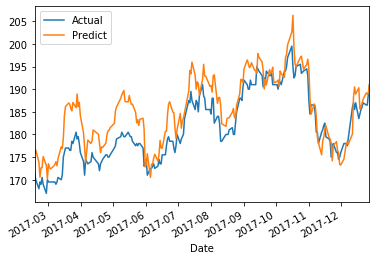

In [65]:
holdout[["Actual", "Predict"]].plot()

In [69]:
mean_squared_error(holdout[["Actual"]].values, holdout[["Predict"]].values)

22.962811068468987

In [72]:
r2_score(holdout[["Actual"]].values, holdout[["Predict"]].values)

0.6016192918844143

In [81]:
mean_absolute_error(holdout[["Actual"]].values, holdout[["Predict"]].values)

3.9854326013116

# Test on holdout: 2018-2020

In [66]:
holdout2 = df["2018-01-01":"2020-04-30"]
holdout2


inputs = {
    'open': holdout2["Open"],
    'high': holdout2["High"],
    'low': holdout2["Low"],
    'close': holdout2["Close"],
    'volume': holdout2["Volume"]
}

holdout2["SMA"] = SMA(inputs, timeperiod=25).tolist()
holdout2["WMA"] = WMA(inputs).tolist()
holdout2["ADOSC"] = ADOSC(inputs).tolist()
holdout2["ATR"] = ATR(inputs).tolist()
holdout2["RSI"] = RSI(inputs).tolist()
holdout2["AD"] = AD(inputs).tolist()

# Tomorrow actual

holdout2["Actual"] = holdout2["Close"].shift(-1)
holdout2.head()

# Start prediction
holdout2 = holdout2.dropna()

holdout2["Predict"] = model.predict(holdout2[["SMA", "WMA", "RSI", "ADOSC", "ATR"]].values)
holdout2

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

,High,Low,Open,Close,Volume,Adj Close,SMA,WMA,ADOSC,ATR,RSI,AD,Actual,Predict
Date,,,,,,,,,,,,,,
2018-02-13,196.0,194.0,194.0,195.5,6603800.0,178.750519,193.66,193.722581,2.743741e+06,2.524966,52.853650,-6.059511e+06,195.0,198.475148
2018-02-14,196.5,195.0,196.5,195.0,3175900.0,178.293350,193.70,193.792473,1.888410e+06,2.451754,51.256530,-9.235411e+06,196.0,197.626378
2018-02-15,196.0,194.5,195.5,196.0,2323000.0,179.207687,193.86,193.930108,2.105964e+06,2.383772,54.235113,-6.912411e+06,195.0,199.207139
2018-02-16,197.0,195.0,196.5,195.0,1881900.0,178.293350,193.98,193.998925,1.404726e+06,2.356360,50.886387,-8.794311e+06,194.0,197.636776
2018-02-19,195.5,193.5,195.0,194.0,2917800.0,177.379044,193.96,194.003226,5.259577e+05,2.330905,47.713702,-1.025321e+07,193.5,195.985218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,202.0,198.0,201.0,199.5,8061100.0,199.500000,195.12,194.375269,6.101807e+06,6.009849,55.078833,7.087142e+07,198.5,198.085238
2020-04-24,200.0,197.0,199.0,198.5,7015600.0,198.500000,195.46,194.809677,6.064094e+06,5.794860,53.913469,7.087142e+07,200.0,198.163140
2020-04-27,201.0,197.5,199.0,200.0,5402400.0,200.000000,195.56,195.287097,6.234076e+06,5.630942,55.436579,7.318673e+07,199.5,199.342922


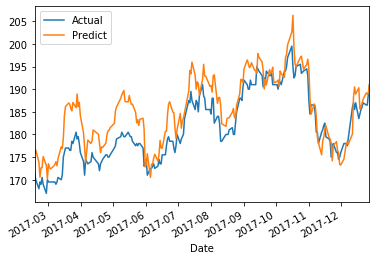

In [67]:
holdout[["Actual", "Predict"]].plot()

In [70]:
mean_squared_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)

19.393330682693417

In [71]:
r2_score(holdout2[["Actual"]].values, holdout2[["Predict"]].values)

0.9257401221946047

In [80]:
mean_absolute_error(holdout2[["Actual"]].values, holdout2[["Predict"]].values)

3.471638068362051